# Short tutorial of `extrapops`:
#### - Generating a population
#### - Drawing some plots
#### - Studying the background
#### - Checking "observable" events

### 1. Load or create a parameter dict

In [1]:
import os
from pprint import pprint
from yaml import safe_load

# Use GWTC-3 median
filename = "gwtc3_median.yaml"
# Use fiducial fixed-point for the Background paper
filename = "N18.yaml"

with open(filename, "r") as f:
    population_params = safe_load("\n".join(f.readlines()))

print("Population parameters:")
pprint(population_params)

# Reducing z and tc range for tests
population_params["redshift"]["z_range"][1] = 4
population_params["redshift"]["T_yr"] = 10

Population parameters:
{'cosmo': {'H_0': 67.9,
           'Omega_k': 0.0,
           'Omega_l': 0.7,
           'Omega_m': 0.3,
           'Omega_r': 0},
 'mass': {'alpha': 3.4,
          'beta_q': 1.1,
          'delta_m': 7.8,
          'lambda_peak': 0.039,
          'm_range': [2.5, 100.0],
          'mu_m': 34,
          'sigma_m': 5.1},
 'redshift': {'T_yr': 10000,
              'merger_rate_model': 'madau',
              'merger_rate_params': {'R_0': 17.3,
                                     'd': 2.7,
                                     'r': -3.6,
                                     'z_0': 0,
                                     'z_peak': 2.04},
              'z_range': [1e-05, 5]},
 'spin': {'expected_a': 0.25, 'sigma_t': 1.5, 'var_a': 0.03, 'zeta_spin': 0.66}}


In [2]:
# Alternative: Merger rate model as a function
def custom_merger_rate(z, R_0=20, kappa=3):
    return R_0 * (1 + z)**kappa

# Uncomment to test it!
# population_params["redshift"]["merger_rate_model"] = custom_merger_rate
# population_params["redshift"]["merger_rate_params"] = {"R_0": 18, "kappa": 2.7}

### 2. Generate a population

In [3]:
from extrapops.population import Population
print("Generating population (this may take a while...)")
# If lazy=True (default) only background-relevant variables are simulated (e.g. spins are not)
pop = Population(lazy=False, **population_params)
print(f"Population generated with {len(pop)} inspirals!")

Generating population (this may take a while...)
cacheteandooooooo!!!!!!!
Population generated with 774137 inspirals!


### 3. Inspect source parameters and do some plots

In [4]:
print("Available quantities to inspect or plot:", pop.source_params)

Available quantities to inspect or plot: ['Redshift', 'Mass1', 'Mass2', 'Distance', 'CoalTime', 'ChirpMass', 'InitialFrequency', 'FinalFrequency', 'InBandTime', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2', 'InitialPhase', 'EclipticLatitude', 'EclipticLongitude', 'Inclination', 'Polarization']


In [5]:
print("Masses and redshifts:")
print(pop[["Mass1", "Mass2", "Redshift"]])

Masses and redshifts:
            Mass1      Mass2  Redshift
0       36.550452  11.560901  0.981309
1        6.993443   6.025526  2.246526
2        7.203109   4.941302  1.896223
3        6.735489   6.682333  1.936653
4        7.183783   6.163469  2.018276
...           ...        ...       ...
774132   5.832915   4.632823  3.684049
774133  23.973860  23.754506  1.910474
774134   6.029344   5.625179  1.510490
774135  10.698327   6.331970  3.755303
774136  40.409885  25.819771  1.540507

[774137 rows x 3 columns]


<Axes: xlabel='Redshift ($z$)', ylabel='$\\mathcal{M}\\;[M_\\odot]$'>

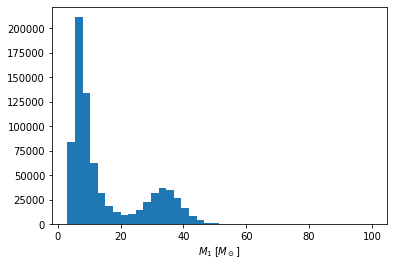

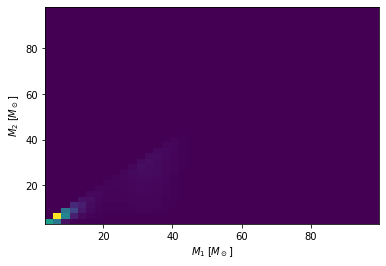

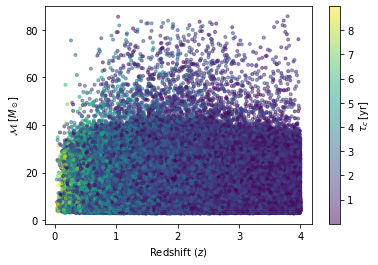

In [6]:
# 1-d histogram
pop.plot("Mass1")
# 2-d histogram
pop.plot("Mass1", "Mass2")
# Scatter plot
pop.plot("Redshift", "ChirpMass", "CoalTime")

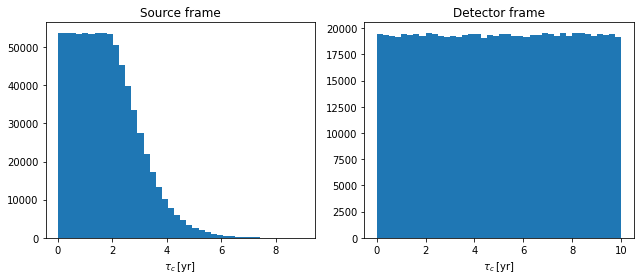

In [7]:
# Choosing reference frame for the plots (default: source frame)
plot_param = "CoalTime"
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
pop.plot(plot_param, ax=ax1)
ax1.set_title("Source frame")
pop.plot(plot_param, frame="detector", ax=ax2)
ax2.set_title("Detector frame")
plt.tight_layout()

### 4. [Optional] Save the population, and load it again

In [8]:
# Put in "output" folder, for tests
from conftest import ensure_output_folder
ensure_output_folder()  # creates './output' folder if it does not exist

# Save
file_name = "testpop"
out_path = os.path.join("output", file_name)
print(f"Saving population at {out_path}...")
# LISA=True (default: False) to save in LISA LDC format
pop.save(out_path, force=True, LISA=True)
print("Population saved!")

# And load it again
print(f"Loading population from {out_path}...")
pop2 = Population(load=out_path)
print("Population loaded!")

Saving population at output/testpop...
Population saved!
Loading population from output/testpop...
Population loaded!


### 5. Compute the background in the LISA band using different methods
#### (NB: this is not the full magnitude of the backgroung, which requires $z_\mathrm{max}\ge 5$)

In [9]:
f_LISA = 3e-3  # Hz
print("Computing integrated (population-averaged) background...")
Omh2_analytic_func = pop.total_strain_squared_avg(omegah2_units=True)
print(f"Averaged background: O_GW h^2 (f={f_LISA}) = {Omh2_analytic_func(f_LISA)}")

Computing integrated (population-averaged) background...


/home/jesus/projects/lisa/extrapops/extrapops/background.py:26: UserWarning: Background would be smaller than actual one, unless z_max>=5
  warn("Background would be smaller than actual one, unless "


Averaged background: O_GW h^2 (f=0.003) = 9.525303083568362e-13


In [10]:
print("Computing MC coal-time-averaged background...")
Omh2_MC_func = pop.total_strain_squared(omegah2_units=True)
print(f"MC coal-time-averaged background: O_GW h^2 (f={f_LISA}) = {Omh2_MC_func(f_LISA)}")

# The expected difference between the two (~ population variance) is of order a few 0.1%
print(f"Relative difference: {100 * abs(Omh2_MC_func(f_LISA)- Omh2_analytic_func(f_LISA)) / Omh2_analytic_func(f_LISA) :.2f}%")

Computing MC coal-time-averaged background...
MC coal-time-averaged background: O_GW h^2 (f=0.003) = 9.55162387828086e-13
Relative difference: 0.28%


In [11]:
print("Computing MC frequency-binned background...")
delta_f = 1 / (24 * 60 * 60)  # 1 day periodogram
freqs_MCbinned, Omh2_MCbinned = pop.total_strain_squared_fbin(delta_f=delta_f, omegah2_units=True)
print("Done!")

Computing MC frequency-binned background...
Done!


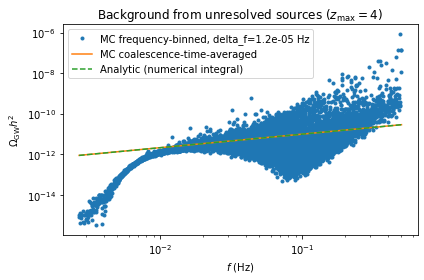

In [12]:
# Notice the effect of limited time-to-coalescence in the binned method at low frequencies.
plt.figure(figsize=(6, 4))
plt.plot(freqs_MCbinned, Omh2_MCbinned, ".",
         label=f"MC frequency-binned, delta_f={delta_f:.2g} Hz")
plt.loglog(freqs_MCbinned, Omh2_MC_func(freqs_MCbinned), label="MC coalescence-time-averaged")
plt.loglog(freqs_MCbinned, Omh2_analytic_func(freqs_MCbinned), "--", label="Analytic (numerical integral)")
plt.title(f"Background from unresolved sources ($z_\mathrm{{max}}={pop.params['redshift']['z_range'][1]}$)")
plt.xlabel(r"$f$ (Hz)")
plt.ylabel(r"$\Omega_\mathrm{GW}h^2$")
plt.legend()
plt.tight_layout()
plt.savefig("output/background.png", dpi=300)

### 6. Study expected observable events, based on **approximate** SNR

In [13]:
# Add approximate SNR based on 4yr LISA observation time
pop.add_snr_avg_inclination(T_obs_yr=4)
# --> adds source parameter "snr_avg_inclination"

In [14]:
# Select events with SNR larger than some value, e.g. 8 for expected detectable events, or 4 for archival search
rho_0 = 4
loud_events = pop[pop["snr_avg_inclination"] > rho_0]

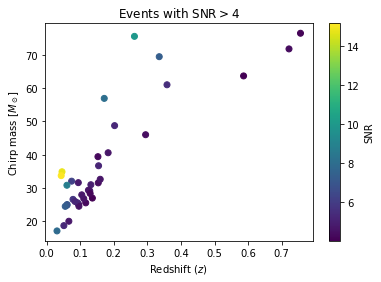

In [15]:
plt.figure()
plt.scatter(loud_events["Redshift"], loud_events["ChirpMass"], c=loud_events["snr_avg_inclination"])
plt.colorbar(label="SNR")
plt.title(f"Events with SNR$>{rho_0}$")
plt.xlabel("Redshift ($z$)")
plt.ylabel(r"Chirp mass [$M_\odot$]")
plt.savefig("output/loud_events.png", dpi=300)